# Clean up NLCD data
This notebook shows how to select the correct subset of the NLCD data, using the traversal data for reference.

Basically, you:
1. Open up the traversal.
2. Add a buffer to the traversal bounds.
3. Use those bounds to select the NLCD data.

*You need to have GDAL installed to do this*

In [6]:
import geopandas as gpd
import rasterio as rio
from matplotlib import pyplot as plt

In [9]:
# This code loads the census tract shapefile for Durham County
trav = gpd.read_file('../data/traversal/Boston_ev.shp')

# Convert to the same coordinate system as the desired NLCD data
# it should always be EPSG:3857 (because that's in meters)
trav = trav.to_crs(epsg=3857)
bounds = trav.total_bounds
print(bounds)

[-7922851.76390963  5197338.18061925 -7905185.54625323  5221224.54178838]


In [10]:
# Add a buffer to the bounds (in meters) to make sure that we have sufficient space around the traversal path.
# I recommend a buffer of 1000 meters, but to be conservative, you could make it 2000 meters, too. 
print('before', bounds)
bounds = [bounds[0]-1000, bounds[1]-1000, bounds[2]+1000, bounds[3]+1000]
print('after', bounds)

before [-7922851.76390963  5197338.18061925 -7905185.54625323  5221224.54178838]
after [-7923851.763909629, 5196338.180619254, -7904185.546253226, 5222224.541788379]


Now, we will run the following bash function to extract out the image as defined by the bounds, in the desired format.

In [36]:
!gdalwarp ../nlcd/nlcd_2021_land_cover_l48_20230630.img -te {bounds[0]} {bounds[1]} {bounds[2]} {bounds[3]} -t_srs EPSG:3857 -tr 10 10 -tap -of GTiff ../data/boston/boston_nlcd.tif

Copying raster attribute table from ../data/nlcd/nlcd_2021_land_cover_l48_20230630.img to new file.
Copying color table from ../data/nlcd/nlcd_2021_land_cover_l48_20230630.img to new file.
Creating output file that is 2770P x 3307L.
Processing ../data/nlcd/nlcd_2021_land_cover_l48_20230630.img [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.


In [25]:
!gdal_rasterize -to SRC_SRS=EPSG:4326 -init 0.0 -a T_C -te {new_bounds[0]} {new_bounds[1]} {new_bounds[2]} {new_bounds[3]} -a_srs EPSG:3857 -tr 10 10 -of GTiff -l Boston_ev ../data/traversal/Boston_ev.shp ../data/boston/boston_temp.tif

0...10...20...30...40...50...60...70...80...90...100 - done.


# Confirming that this worked.

In [26]:
with rio.open('../data/boston/boston_temp.tif') as src:
    temp = src.read(1)
    bounds = src.bounds 
    print(bounds)

with rio.open('../data/boston/boston_ndvi.tif') as src:
    ndvi = src.read(1)
    new_bounds = src.bounds 
    print(new_bounds)

print(temp.shape)
print(ndvi.shape)

BoundingBox(left=-7926540.0, bottom=5192990.0, right=-7898840.0, top=5226060.0)
BoundingBox(left=-7926540.0, bottom=5192990.0, right=-7898840.0, top=5226060.0)
(3307, 2770)
(3307, 2770)


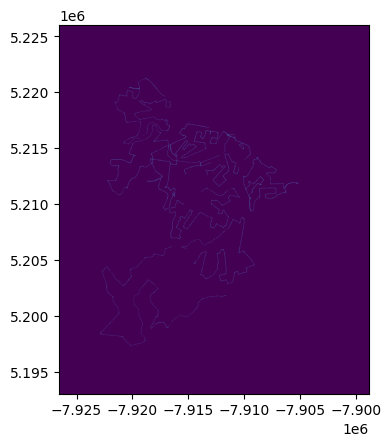

In [27]:
plt.imshow(temp, extent=(new_bounds[0], new_bounds[2], new_bounds[1], new_bounds[3]), cmap='viridis')

NOTE THE DIFFERENCE
[-8791553.427730994, 4260027.561971332, -8739278.76270148, 4309026.237485317]
BoundingBox(left=-8791560.0, bottom=4260000.0, right=-8739270.0, top=4309050.0)


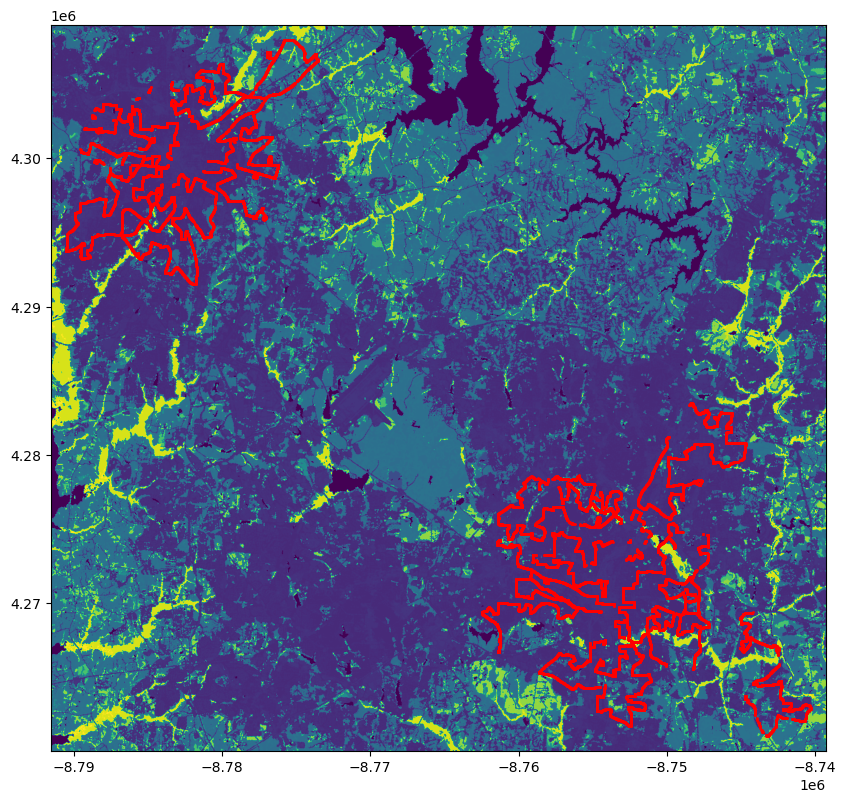

In [9]:
# Open up the file, and plot it to make sure it looks right
# import cartopy.crs as ccrs

with rio.open('../data/durham.tif') as src:
    durham = src.read(1)
    new_bounds = src.bounds

print("NOTE THE DIFFERENCE")
print(bounds)
print(new_bounds)

plt.figure(figsize=(10,10))

# Plot the raster data
plt.imshow(durham, extent=(bounds[0], bounds[2], bounds[1], bounds[3]), cmap='viridis')
# Plot the points on top
plt.scatter(trav.geometry.x, trav.geometry.y, c='r', s=1)
plt.show()

So, you'll note that this actually shows Durham and Raleigh -- that's because the traversal data for Raleigh and Durham is in the same file. Previously, I subset the bounds to only look at the traversal in Durham.

Also, you'll see that the bounds are *slightly* different. This is because of the `--tap` option used in the bash command. This ensures that subsetted dataset that we generated snaps to the gridlines used in the original dataset. In this example, NLCD is at a 30m resolution, so the bounds snap to the nearest 30 meter bound.

Let me know if this doesn't make sense!